# Metric 1: Monthly bookings growth rate

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from file_utils import read_from_pickle

In [2]:
df_listings = read_from_pickle('./data/df_listings.pkl')
df_contacts = read_from_pickle('./data/df_contacts.pkl')
df_users = read_from_pickle('./data/users.pkl', )

In [3]:
df_contacts['ts_booking_at'].isnull().value_counts()

ts_booking_at
True     16299
False    11587
Name: count, dtype: int64

## Checking for outliers

In [4]:
df_matching = pd.DataFrame(data={
    'period': df_contacts['ts_interaction_first'].dt.to_period(freq='M').astype(str),
    'current': df_contacts.index
}).groupby(by=['period'], group_keys=True).count()
df_matching


,current
period,
2016-01,7617
2016-02,4071
2016-03,3817
2016-04,3716
2016-05,4304
2016-06,4361


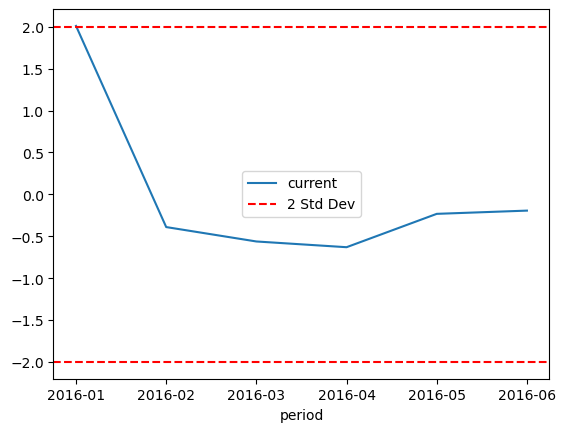

In [5]:
def zscores(series, x=2):
    mean = series.mean()
    std_dev = series.std()
    threshold = x * std_dev
    zscore_series = (series - mean) / std_dev
    return {
        'zscores': zscore_series,
        'threshold': threshold,
        'mean': mean,
        'std_dev': std_dev,
        'max_threshold': mean + threshold,
        'min_threshold': mean - threshold
    }
    
# plot with threshold lines and zscore
x = 2
zscore = zscores(df_matching['current'], x)
zscore['zscores'].plot()
plt.axhline(x, color='r', linestyle='--', label=f'{x} Std Dev')
plt.axhline(-x, color='r', linestyle='--')
plt.legend()
plt.show()


## Create adjusted values based on zscores

In [6]:
df_matching['adjusted'] = df_matching['current'].apply(lambda x: zscore['max_threshold'] if x > zscore['max_threshold'] else x)
df_matching['adjusted'] = df_matching['adjusted'].apply(lambda x: zscore['min_threshold'] if x < zscore['min_threshold'] else x)
df_matching

,current,adjusted
period,,
2016-01,7617,7601.684857
2016-02,4071,4071.000000
2016-03,3817,3817.000000
2016-04,3716,3716.000000
2016-05,4304,4304.000000
2016-06,4361,4361.000000


## Monthly Trend Analysis

In [7]:
def hw_trend(series, smoothing_level=None, smoothing_trend=None, freq='MS'):
    model = ExponentialSmoothing(series, freq=freq, trend='add', damped_trend=False , seasonal=None).fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend)
    print('hw params', model.params)
    print('sse', model.sse)
    print('aic', model.aic)
    return pd.DataFrame(data={
        'adjusted': series,
        'level': model.level,
        'trend': model.trend,
        'resid': model.resid,
        'fitted': model.fittedvalues,
    })

# df_hw = hw_trend(df_matching['adjusted'], smoothing_level=None, smoothing_trend=None)
df_hw = hw_trend(df_matching['adjusted'], smoothing_level=0.05, smoothing_trend=0.3)

hw params {'smoothing_level': 0.05, 'smoothing_trend': 0.3, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 6163.225483095633, 'initial_trend': -443.9887440987527, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
sse 7902665.56650901
aic 92.54570722868132


### Residuals: Z-score plot and autocorrelation stats

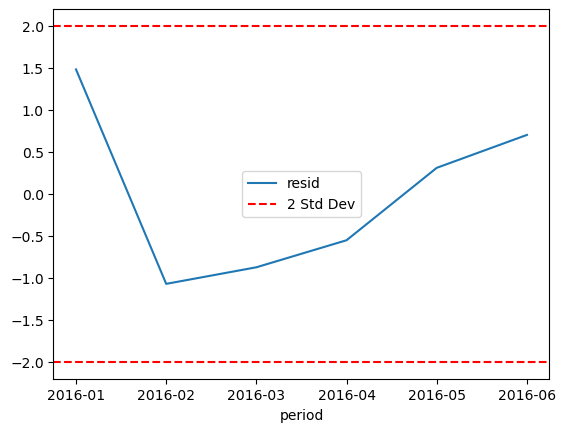

    lb_stat  lb_pvalue
1  0.005856   0.939004


In [8]:
x = 2
zscore = zscores(df_hw['resid'], x)
zscore['zscores'].plot()
plt.axhline(x, color='r', linestyle='--', label=f'{x} Std Dev')
plt.axhline(-x, color='r', linestyle='--')
plt.legend()
plt.show()


# Ljung-Box test for autocorrelation in residuals
acorr = acorr_ljungbox(df_hw['resid'])
print(acorr)

In [9]:
df_hw

,adjusted,level,trend,resid,fitted
period,,,,,
2016-01,7601.684857,5813.359145,-415.752022,1882.448118,5719.236739
2016-02,4071.000000,5331.276766,-435.651129,-1326.607123,5397.607123
2016-03,3817.000000,4841.694355,-451.830514,-1078.625637,4895.625637
2016-04,3716.000000,4356.170650,-461.938471,-673.863842,4389.863842
2016-05,4304.000000,3914.720569,-455.791954,409.767822,3894.232178
2016-06,4361.000000,3504.032185,-442.260883,902.071385,3458.928615


### Trend component plot

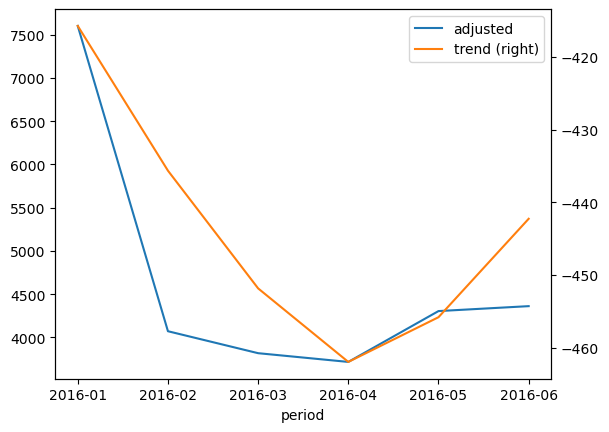

In [10]:
df_hw.plot(y=['adjusted', 'trend'], secondary_y='trend', kind='line')
plt.show()


### Metric 1: Monthly bookings growth rate

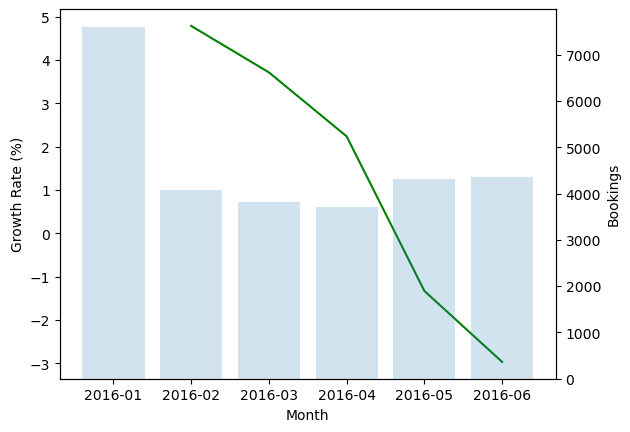

In [11]:
df_hw['growth_rate'] = df_hw['trend'].pct_change()
df_hw['growth_rate'] = df_hw['growth_rate'] * 100

# Plot growth rate line as percentage and bar for 'ajusted' bookings
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_hw['growth_rate'], color='g')
ax2.bar(df_hw.index, df_hw['adjusted'], alpha=0.2)

## add labels
ax1.set_xlabel('Month')
ax1.set_ylabel('Growth Rate (%)')
ax2.set_ylabel('Bookings')

plt.show()

In [12]:
df_hw['growth_rate']

period
2016-01         NaN
2016-02    4.786292
2016-03    3.713840
2016-04    2.237113
2016-05   -1.330592
2016-06   -2.968695
Name: growth_rate, dtype: float64